# Détection de trajectoires anormales pour la surveillance maritime

La détection d'anomalies, est une problématique importante en apprentissage automatique et analyse de données. Le concept d'anomalie fait référence à des observations ou des comportements atypiques par rapport à la norme, souvent susceptibles d'indiquer des situations inattendues ou des incidents potentiellement préjudiciables. Pendant les 2 prochaines séances, nous explorerons diverses approches de détection d'anomalies, que nous illustrerons sur des données de trajectoires de navires.

<center>
<img src="https://drive.google.com/uc?id=1m7Tar-_SAsEM05wvhK5Nf72Q11h-etpL">
</center>

Ces trajectoires, représentent des déplacements de navires à travers une séquences de 16 coordonnées $(x, y)$, et peuvent révéler des schémas de comportement normaux, mais également des situations anormales telles que des déviations de routes ou des activités inattendues en mer.

Nous approcherons de problème de deux manières différentes : la détection d'anomalies supervisée dans un premier temps (TP 1), et la détection d'anomalies non-supervisée pour le TP 2.

Le premier TP consistera en un rappel des notions vues en Analyse de Données au 1er semestre, et à l'introduction de l'environnement de travail pour les séances de TP de ce semestre, à savoir Python à travers les librairies *NumPy*, *Scikit-learn* (et plus tard, *Keras* et *Tensorflow*). Nous commencerons par projeter les données dans un espace à plus faible dimension à l'aide de l'Analyse en Composante Principales, puis nous testerons deux algorithmes d'apprentissage supervisé, à savoir les Support Vector Machines (SVM) et les forêts aléatoires. Ces méthodes s'appuient sur des **ensembles d'entraînement étiquetés** pour apprendre à discriminer les trajectoires normales des anomalies.

Dans le second volet, nous nous tournerons vers des approches de détection d'anomalies non-supervisées. Nous examinerons l'utilisation de LOF (Local Outlier Factor), un algorithme basé sur la densité locale, ainsi que One-Class SVM, une méthode qui apprend à définir la région normale de l'espace des données sans nécessiter d'exemples d'anomalies.


## Préambule : la librairie NumPy


**NumPy** est une bibliothèque fondamentale en Python dédiée principalement à la manipulation et au calcul numérique. Elle offre une structure de données appelée `NumPy array` qui est au cœur de son fonctionnement. Voici quelques points clés sur le fonctionnement de la bibliothèque NumPy et le type `NumPy array` :

Le `NumPy array` est une structure de données multidimensionnelle qui permet de stocker des données de manière efficace.
Il peut être utilisé pour représenter des tableaux unidimensionnels (vecteurs), bidimensionnels (matrices), ou même de dimensions supérieures.






In [ ]:
import numpy as np

# Création de numpy arrays
array1d = np.array([1, 2, 3, 4, 5])
matrix2d = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])

# Affichage des résultats
print("Vecteur :", array1d)
print("Matrice :\n", matrix2d)

Comme dans Matlab, il est possible d'accéder à des éléments de la structure de données, seuls ou en groupe :

In [ ]:
# Accès aux éléments
element_at_index_2 = array1d[2]
print("Elément à l'indice 2 du vecteur :", element_at_index_2)

last_element = array1d[-1]
print("Dernier élément du vecteur :", last_element)

element_at_row_1_col_2 = matrix2d[1, 2]
print("Elément à la ligne 1, colonne 2 de la matrice :", element_at_row_1_col_2)

col_2 = matrix2d[:,2]
print("Colonne 2 de la matrice :", col_2)

**Prenez garde : en Python, les indices commencent à 0 et pas à 1 comme en Matlab !!**


NumPy fournit des fonctions pour effectuer des opérations mathématiques et statistiques sur les numpy arrays.
Ces opérations sont optimisées, améliorant ainsi la performance par rapport aux boucles traditionnelles en Python.

In [ ]:
# Fonctions statistiques
mean_value = np.mean(array1d)
print("Valeur moyenne du vecteur : ", mean_value)
max_value = np.max(matrix2d)
print("Valeur maximale de la matrice : ", max_value)


Toutes les fonctions d'algèbre linéaire sont également implémentées, par exemple :

In [ ]:
# Algèbre linéaire
eigenvalues, eigenvectors = np.linalg.eig(matrix2d)

print("Valeurs propres :", eigenvalues)
print("Vecteurs propres : \n", eigenvectors)

Pendant les TP, je vous indiquerai toujours les fonctions NumPy pertinentes à utiliser, en revanche charge à vous d'aller visiter la [documentation](https://numpy.org/doc/stable/index.html) pour trouver comment appeler ces fonctions !

## Chargement des données

Commençons par récupérer les données au format texte sur l'URL suivante :

In [1]:
!wget -O donnees.txt "https://drive.google.com/uc?export=download&id=1pBTRdWAX98p_FPm41x3F9z0BOGow4egu"

--2024-02-06 16:32:20--  https://drive.google.com/uc?export=download&id=1pBTRdWAX98p_FPm41x3F9z0BOGow4egu
Resolving drive.google.com (drive.google.com)... 142.250.200.238, 2a00:1450:4006:80d::200e
Connecting to drive.google.com (drive.google.com)|142.250.200.238|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1pBTRdWAX98p_FPm41x3F9z0BOGow4egu&export=download [following]
--2024-02-06 16:32:20--  https://drive.usercontent.google.com/download?id=1pBTRdWAX98p_FPm41x3F9z0BOGow4egu&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 172.217.19.129, 2a00:1450:4006:806::2001
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|172.217.19.129|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133640 (131K) [application/octet-stream]
Saving to: ‘donnees.txt’

donnees.txt         100%[===================>] 130,51K  --.-KB/s    in 0,1s

Ce fichier contient les données au format texte : chaque ligne correspond à une trajectoire de navire.

Une trajectoire est définie par une séquence de 16 paires de coordonnées $(x_i, y_i)$, $i=1..16$.

Chaque trajectoire constitue une ligne du fichier texte, organisée comme suit : $x_1, x_2, ..., x_{16}, y_1, y_2, ..., y_{16}$

Les 250 premières trajectoires correspondent à des trajectoires normales, et les 10 dernières sont des anomalies.

**Travail à faire :** Complétez le code ci-dessous, en utilisant notamment la fonction `shape` de la librairie NumPy.

In [14]:
import numpy as np

# Lecture de la base de données et mise en forme des données
def read_dataset(file_path):
    data = np.loadtxt(file_path) # Lecture des données dans un numpy array de dimension (260, 32)

    # Nombre de trajectoires de la base de données
    # A COMPLETER
    num_trajectories = data.shape[0]

    # Séparation des trajectoires normales et anormales (anomalies)
    # A COMPLETER
    X_normal = data[:250]
    X_anomaly = data[250:]

    return X_normal, X_anomaly

X_normal, X_anomaly = read_dataset('donnees.txt')

La fonction suivante permet d'afficher les trajectoires :

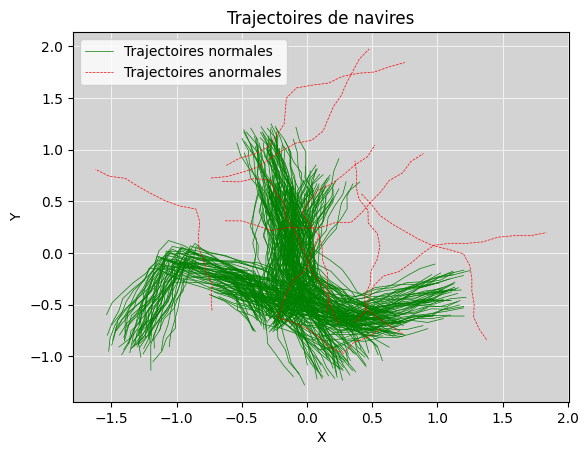

In [15]:
import matplotlib.pyplot as plt

def plot_trajectories(normal_trajectories, anomaly_trajectories):
    # Affichage des trajectoires normales en vert
    plt.plot([], [], color='green', linewidth=0.5, label='Trajectoires normales')
    for traj in normal_trajectories:
        # Les 16 premières coordonnées sont les abscisses des points de la trajectoire
        x = traj[:16]
        # Les 16 coordonnées suivantes sont les ordonnées des points de la trajectoire
        y = traj[16:]
        plt.plot(x, y, color='green', linewidth=0.5)


    # Affichage des trajectoires anormales en rouge et pointillés
    plt.plot([], [], color='red', linestyle='dashed', linewidth=0.5, label='Trajectoires anormales')
    for traj in anomaly_trajectories:
        x = traj[:16]
        y = traj[16:]
        plt.plot(x, y, color='red', linestyle='dashed', linewidth=0.5)

    # Labels d'axes et titre
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Trajectoires de navires')

    # Couleur de fond et grille
    plt.gca().set_facecolor('lightgrey')
    plt.grid(color='white', linestyle='-', linewidth=0.5)

    # Ajout de la légende
    plt.legend()

    # Affichage de la figure
    plt.show()


plot_trajectories(X_normal, X_anomaly)

## TP 1 - Détection d'anomalies supervisée

Ce premier TP constitue à la fois une mise en route dans l'environnement Python, et une révision des notions vues en Analyse de Données au 1er semestre.

On se place donc dans le cadre de l'apprentissage supervisé : on suppose que nos données sont étiquetées. Ainsi, à chaque donnée $x$ (une trajectoire), on peut associer une étiquette (ou un label) $y$ : 0 si c'est une anomalie, 1 si la trajectoire est normale.

In [16]:
X = np.concatenate([X_normal, X_anomaly])
Y = np.concatenate([np.ones(X_normal.shape[0]), np.zeros(X_anomaly.shape[0])])
X.shape, Y.shape

((260, 32), (260,))

On se place donc dans le cadre de la classification binaire, pour laquelle nous avons vu plusieurs méthodes au 1er semestre : classification bayésienne, SVM ou encore arbres de décision.

Le schéma général d'une application d'apprentissage supervisé est le suivant :

<img src="https://drive.google.com/uc?id=1qY6sq_1hXWugsGKad2dl26LdYFyyX-o5" width=600>

A partir de l'acquisition d'un motif ("forme") par un capteur, on réalise un pré-traitement dont le but est souvent de diminuer la dimension de l'espace des données. Une phase d'apprentissage est réalisée pour entraîner un modèle, qui sert ensuite à prendre des décisions sur de nouvelles données (dans une phase dite d'inférence).


<img src="https://drive.google.com/uc?id=1ZkrUAmCMMWiwWWoY_lw9sAe8vCS2ExA6" width=600>


Dans ce TP, nous classifierons des trajectoires de navire dont nous allons préalablement réduire la dimension grâce à l'ACP. Puis nous appliquerons un SVM pour apprendre à séparer les trajectoires normales des anomalies.

### 1.1 - Analyse en Composantes Principales

L'analyse en composantes principales est une technique de réduction de dimension dont l'objectif est de projeter les données dans un espace de faible dimension grâce à une transformation linéaire. Cette projection est réalisé avec l'objectif de maximiser la dispersion (variance) des données projetées.

**Travail à faire :** Complétez la fonction compute_pca qui réalise la projection des données `data` sur les `num_axis` premiers axes de l'ACP. Pour rappel, la base de l'ACP est obtenue en diagonalisant la matrice de variance-covariance des données, et en récupérant les `num_axis` vecteurs propres corresondant aux plus grandes valeurs propres.

**Indications :** Pour écrire cette fonction, vous aurez certainement besoin des fonctions NumPy suivantes : `mean`, `cov` (prenez garde à l'argument `rowvar`), `eig`, `argsort` (Attention, le tri est dans l'ordre croissant), `flip` et `matmul`. A vous de lire la documentation de ces fonctions avec attention pour les utiliser corectement.

In [17]:
# Fonction de projection des données sur les num_axis premiers axes de l'ACP
# A COMPLETER
def compute_pca(data, num_axis=2):
    # Etape 1: Centrage des données
    centered_data = data - np.mean(data,axis=0)

    # Etape 2: Calcul de la matrice de variance-covariance
    mat_cov = np.cov(centered_data, rowvar=False)

    # Etape 3: Calcul des couples propres de la matrice de variance-covariance
    eigval, eigvect = np.linalg.eig(mat_cov)

    # Etape 4: Réorganisation des vecteurs propres selon l'ordre des valeurs propres décroissantes
    sorted_ind = np.flip(np.argsort(eigval))
    sorted_eigvect = eigvect[sorted_ind]

    # Etape 5: Récupération des num_axis premiers vecteurs propres
    top_eigvect = sorted_eigvect[:,:num_axis]

    # Etape 6: Projection des données sur les axes de l'ACP
    projected_data = np.matmul(centered_data, top_eigvect)

    return projected_data

Une fois la fonction écrite, testez là avec le bloc de code suivant et vérifiez que votre ACP est correcte !

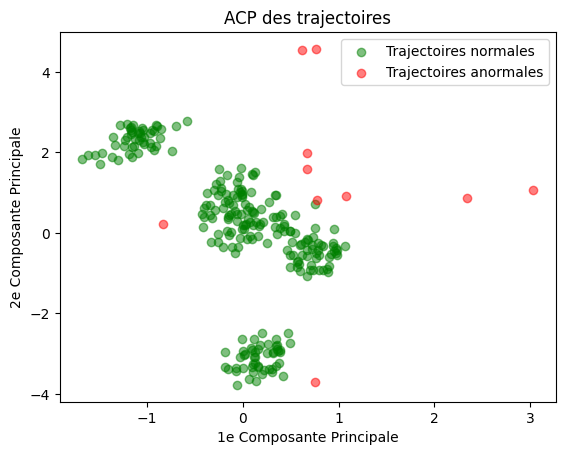

In [18]:
# Projection des trajectoires normales et anormales dans les plan des 2 premiers axes de l'ACP
X_pca = compute_pca(X, num_axis=2)

# Affichage des trajectoires dans le plan des 2 premiers axes de l'ACP
plt.scatter(X_pca[:250, 0], X_pca[:250, 1], color='green', label='Trajectoires normales', alpha=0.5)
plt.scatter(X_pca[250:, 0], X_pca[250:, 1], color='red', label='Trajectoires anormales', alpha=0.5)

# Labels d'axes et titre
plt.xlabel('1e Composante Principale')
plt.ylabel('2e Composante Principale')
plt.title('ACP des trajectoires')

# Légende
plt.legend()

# Affichage de la figure
plt.show()

```
Résultat attendu :
```
<img src="https://drive.google.com/uc?id=1k4-OxZrM3muPxI57LX_BKydaCKrePSCq">




Le résultat est satisfaisant : les anomalies sont assez bien séparées des trajectoires normales dans le plan de l'ACP. Il reste à entraîner un classifieur binaire pour apprendre à séparer les 2 classes. Le classifieur bayésien que nous avons vu au 1er semestre n'est pas très adapté, car ni les trajectoires normales ni les anomalies ne suivent une loi gaussienne. On va donc pour cette classification utiliser un **SVM**.

### 1.2 - Classification des anomalies par SVM

Dans un premier temps, exécutez le bloc de code ci-dessous afin de pouvoir disposer d'une fonction de visualisation de la frontière de décision.

In [19]:
def plot_decision_boundary(X, y, model, title):
    h = .02  # Step size in the mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlGn, alpha=0.3)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlGn, edgecolors='k', marker='o')
    plt.title(title)
    plt.xlabel('1e Composante Principale')
    plt.ylabel('2e Composante Principale')

    plt.show()

Nous allons commencer par séparer notre ensemble de données en un ensemble d'apprentissage (pour entraîner le modèle) et un ensemble de test (pour évaluer la capacité de généralisation du modèle).

In [21]:
from sklearn.model_selection import train_test_split

# Séparation des données en ensembles d'apprentissage (80% des données) et de test (20%)
# Le paramètre stratify assure une bonne représentation des anomalies dans les 2 ensembles
X_train, X_test, y_train, y_test = train_test_split(X_pca, Y, test_size=0.2, random_state=5, stratify=Y)

Les SVM ne sont plus au programme de ce semestre, nous n'allons donc cette fois pas les implémenter nous-même, mais plutôt utiliser la classe `SVC` (pour Support Vector Classification) de la librairie `scikit-learn`.

**Travail à faire :**

*   Complétez le code ci-dessous pour entraîner un SVM à noyau gaussien (indiquez la valeur 1 pour le paramètre $\gamma$) et marge souple (utilisez 1 comme valeur de $C$).

*   Complétez également les lignes permettant de calculer le nombre de faux/vrais positifs/négatifs afin d'afficher la matrice de confusion du modèle. Pour cela les fonctions `logical_and` et `count_nonzero` pourront vous être utiles.



Pourcentage de bonnes classifications sur l'ensemble de test : 100.00%
Matrice de confusion :
------------------------
| pred/true |  0  |  1  |
------------------------
|     0     |   2 |   0 |
------------------------
|     1     |   0 |  50 |
------------------------


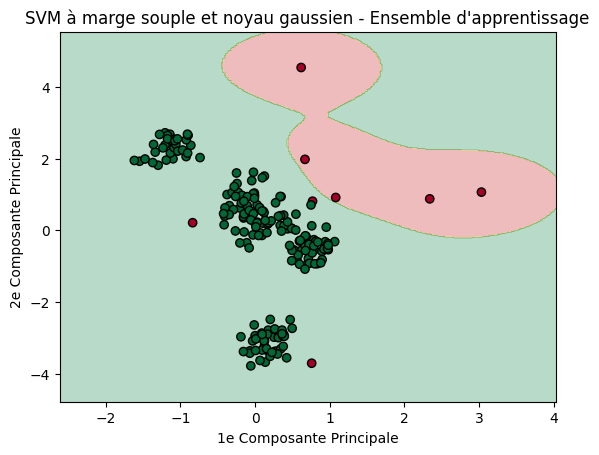

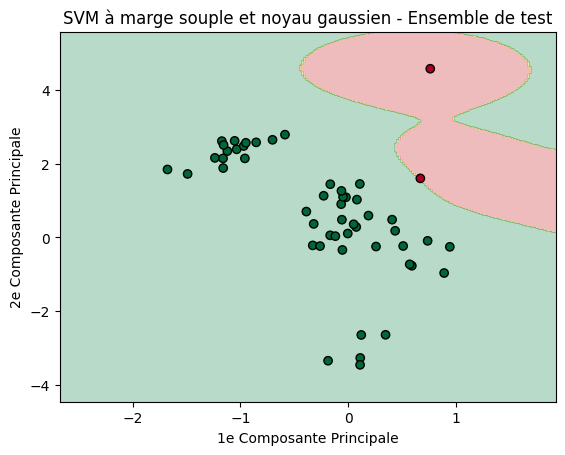

In [28]:
from sklearn.svm import SVC

# Entraînement d'un modèle SVM avec noyau gaussien et marge souple
# A COMPLETER
svm_model = SVC(kernel='rbf',C=1,gamma=1)
svm_model.fit(X_train,y_train)

# Évaluation du modèle sur l'ensemble de test
accuracy = svm_model.score(X_test, y_test)
print(f"Pourcentage de bonnes classifications sur l'ensemble de test : {100*accuracy:.2f}%")

# Calcul des prédictions du modèle sur l'ensemble de test
y_pred = svm_model.predict(X_test)
# A COMPLETER
TP = np.count_nonzero(np.logical_and(y_pred,y_test))
TN = np.count_nonzero(np.logical_and(1-y_pred,1-y_test))
FP = np.count_nonzero(np.logical_and(y_pred,1-y_test))
FN = np.count_nonzero(np.logical_and(1-y_pred,y_test))

print("Matrice de confusion :")
print("------------------------")
print("| pred/true |  0  |  1  |")
print("------------------------")
print(f"|     0     | {TN:3d} | {FN:3d} |")
print("------------------------")
print(f"|     1     | {FP:3d} | {TP:3d} |")
print("------------------------")

# Affichage de la frontière de décision
plot_decision_boundary(X_train, y_train, svm_model, "SVM à marge souple et noyau gaussien - Ensemble d'apprentissage")
plot_decision_boundary(X_test, y_test, svm_model, "SVM à marge souple et noyau gaussien - Ensemble de test")

```
Résultat attendu :

Pourcentage de bonnes classifications sur l'ensemble de test : 98.08%
Matrice de confusion :
------------------------
| pred/true |  0  |  1  |
------------------------
|     0     |   1 |   0 |
------------------------
|     1     |   1 |  50 |
------------------------
```

<img src="https://drive.google.com/uc?id=1_35wRJXo447re6B1ymmsHLAUGWKn241b" width=500>
<img src="https://drive.google.com/uc?id=1XDpmaWfJmSO7T0w7ljd-eE_Sqd0IblPb" width=500>


**Travail à faire :** Observez l'impact des différentes valeurs de $\gamma$ et $C$ sur la frontière de décision. Testez (au moins) 2 valeurs supplémentaires pour chacun de ces paramètres (un très petit et un très grand).

### Forêts aléatoires

Pour terminer ce TP, testez maintenant l'algorithme des forêts aléatoires sur cette base de données. A vous de trouver comment faire en utilisant la bonne fonction de `scikit-learn` et en réutilisant le code écrit pour le SVM.

Pourcentage de bonnes classifications sur l'ensemble de test : 100.00%
Matrice de confusion :
------------------------
| pred/true |  0  |  1  |
------------------------
|     0     |   2 |   0 |
------------------------
|     1     |   0 |  50 |
------------------------


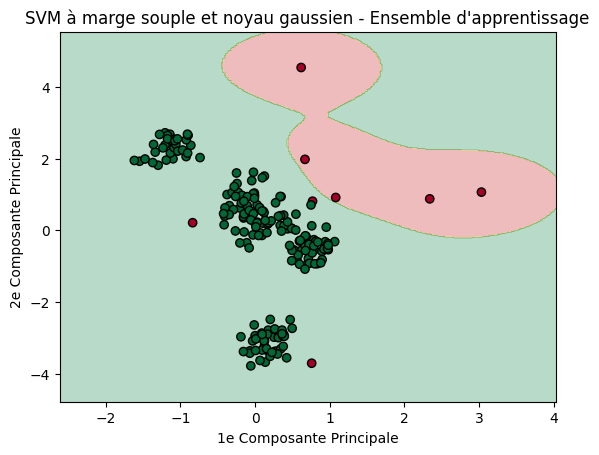

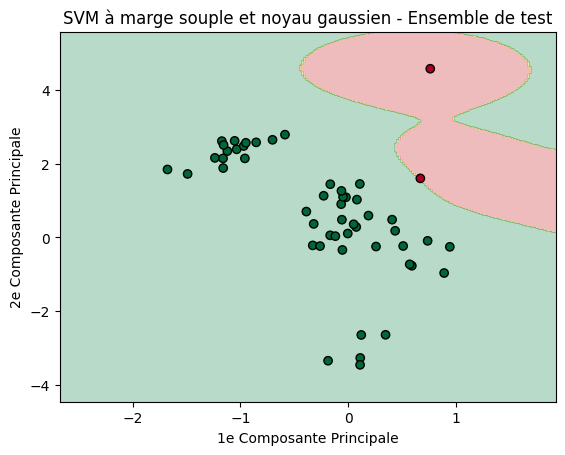

In [30]:
from sklearn.ensemble import RandomForestClassifier

# Entraînement d'un modèle SVM avec noyau gaussien et marge souple
# A COMPLETER
rfd_model = RandomForestClassifier()
rfd_model.fit(X_train,y_train)

# Évaluation du modèle sur l'ensemble de test
accuracy = rfd_model.score(X_test, y_test)
print(f"Pourcentage de bonnes classifications sur l'ensemble de test : {100*accuracy:.2f}%")

# Calcul des prédictions du modèle sur l'ensemble de test
y_pred = rfd_model.predict(X_test)
# A COMPLETER
TP = np.count_nonzero(np.logical_and(y_pred,y_test))
TN = np.count_nonzero(np.logical_and(1-y_pred,1-y_test))
FP = np.count_nonzero(np.logical_and(y_pred,1-y_test))
FN = np.count_nonzero(np.logical_and(1-y_pred,y_test))

print("Matrice de confusion :")
print("------------------------")
print("| pred/true |  0  |  1  |")
print("------------------------")
print(f"|     0     | {TN:3d} | {FN:3d} |")
print("------------------------")
print(f"|     1     | {FP:3d} | {TP:3d} |")
print("------------------------")

# Affichage de la frontière de décision
plot_decision_boundary(X_train, y_train, svm_model, "SVM à marge souple et noyau gaussien - Ensemble d'apprentissage")
plot_decision_boundary(X_test, y_test, svm_model, "SVM à marge souple et noyau gaussien - Ensemble de test")